Architectures to try:
- BERT (RoBERTa, etc.)
- SentenceBert
- Universal Sentence Encoder
- ELECTRA

https://huggingface.co/emilyalsentzer/Bio_ClinicalBERT  
https://huggingface.co/medicalai/ClinicalBERT

https://huggingface.co/nlpie

TODO: https://huggingface.co/datasets/Elfsong/ClinicalDataset

In [1]:
from typing import Union

from transformers import AutoModel, AutoTokenizer
import torch
from tqdm.auto import tqdm

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


In [2]:
models_to_test = [
    "emilyalsentzer/Bio_ClinicalBERT",
    "medicalai/ClinicalBERT",
    "pritamdeka/S-Biomed-Roberta-snli-multinli-stsb",
    # "menadsa/S-Bio_ClinicalBERT", broken???
    "menadsa/S-BioELECTRA",
    "TimKond/S-BioLinkBert-MedQuAD",
    "TimKond/S-PubMedBert-MedQuAD",
    "kamalkraj/bioelectra-base-discriminator-pubmed"
]

In [4]:
class EmbedModel:
    def __init__(self, model_name:str, mode:str="token", device:str="cpu") -> None:
        self.model = AutoModel.from_pretrained(model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.device = device
        self.mode = mode
        self.model.to(self.device)
    
    def __call__(self, text:Union[str, list]):
        tokenized = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
        with torch.no_grad():
            emb = self.model(**tokenized)
        pooled = self._pool(emb, tokenized['attention_mask'])
        # return pooled
        return self._norm(pooled)
    
    def _norm(self, pooled):
        return pooled / torch.linalg.norm(pooled, dim=1, keepdim=True)

    def _pool(self, emb, mask=None):
        if self.mode=="token":
            masked = emb['last_hidden_state']*mask.unsqueeze(-1)
            return masked.sum(axis=1) / mask.sum(-1, keepdim=True)
        elif self.mode=="pooler":
            return emb['pooler_output']

In [5]:
emb_model = EmbedModel(models_to_test[-3], device=device)

# small smoke test
a = emb_model("text")
print(a.square().sum().sqrt())

print(emb_model("tumor in the chest") @ emb_model("lungs cancer").T)

tensor(1.0000, device='cuda:0')
tensor([[0.9814]], device='cuda:0')


## Evaluation of embeddings

In [7]:
from datasets import load_dataset

sample_size = 1000
seed=1337

# dataset 1
data = load_dataset("medmcqa", split="train").to_pandas()
data = data.dropna()
ans_dict = {
    0: "opa",
    1: "opb",
    2: "opc",
    3: "opd"
}
data['Q'] = data['question']
data['A'] = data.apply(lambda row: row[ans_dict[row["cop"]]]+". "+row['exp'], axis=1)
data = data[['Q', "A"]]
print("Length:", len(data))
# data["text"] = data["question"] + "\n" + data["exp"]
# data = data[data["subject_name"] == "Medicine"]
data = data.sample(sample_size, random_state=seed)


# dataset 2
data1 = load_dataset("AnonymousSub/MedQuAD_47441_Question_Answer_Pairs", split="train").to_pandas()
data1 = data1.dropna()
data1["Q"] = data1["Questions"]
data1["A"] = data1["Answers"]
data1 = data1[["Q", "A"]]
print("Length:", len(data1))


data1 = data1.sample(sample_size, random_state=seed)

Using custom data configuration default
Found cached dataset medmcqa (C:/Users/vasec/.cache/huggingface/datasets/medmcqa/default/1.1.0/f2fdfa9ccfbf9d148c0639e6afe3379f3c7e95c4d52d5e68ec1156e5004bd880)


Length: 87077


Using custom data configuration AnonymousSub--MedQuAD_47441_Question_Answer_Pairs-5625072dd394af39
Found cached dataset parquet (C:/Users/vasec/.cache/huggingface/datasets/AnonymousSub___parquet/AnonymousSub--MedQuAD_47441_Question_Answer_Pairs-5625072dd394af39/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


Length: 16407


In [10]:
def encode_db(db, emb, tqdm_flag=True, batch_len=1):
    batches = range(0, len(db), batch_len)
    batched = (db[i:i+batch_len] for i in batches)
    if tqdm_flag:
        proxy = tqdm(batched, total=len(db)/batch_len)
    else:
        proxy = batched
    embeded = torch.cat([emb(batch) for batch in proxy], dim=0)
    return embeded


# TODO: different distance merics
def get_sorted_by_query(query, db):
    pass

'MODEL: emilyalsentzer/Bio_ClinicalBERT'

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


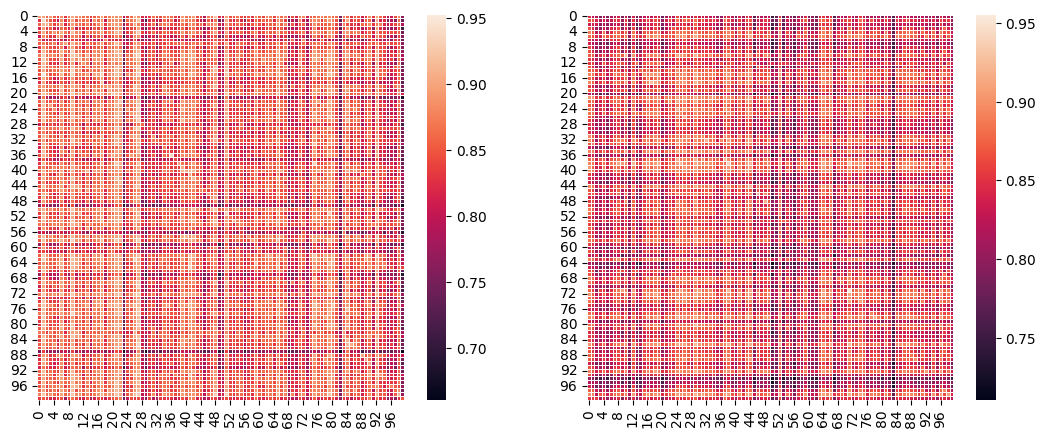

'----------------------------------------------------------------------------------------------------'

'MODEL: medicalai/ClinicalBERT'

Some weights of the model checkpoint at medicalai/ClinicalBERT were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


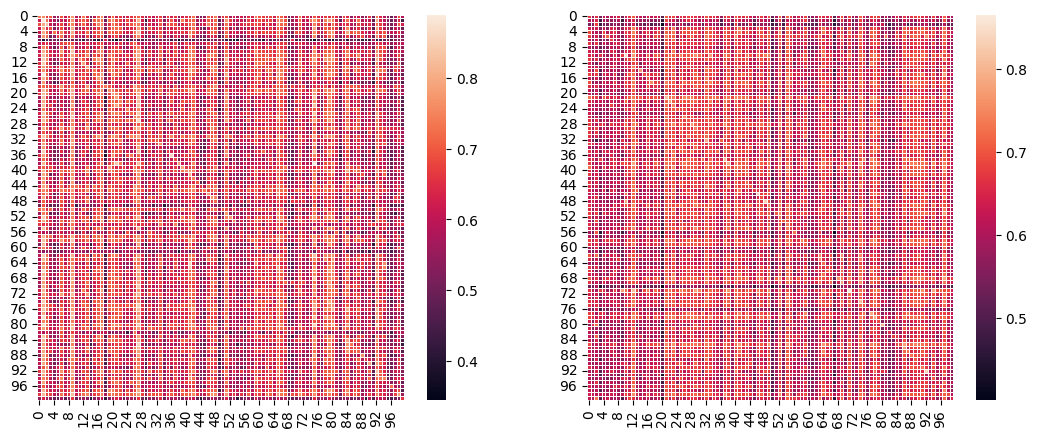

'----------------------------------------------------------------------------------------------------'

'MODEL: pritamdeka/S-Biomed-Roberta-snli-multinli-stsb'

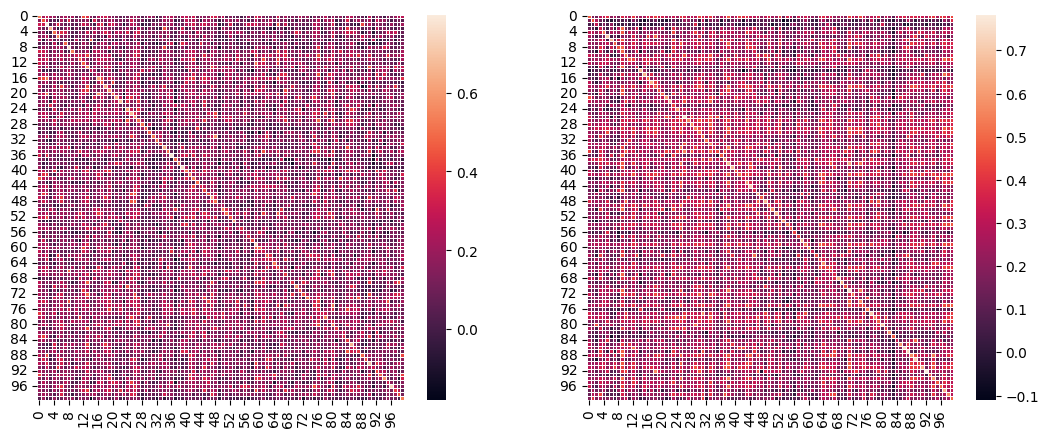

'----------------------------------------------------------------------------------------------------'

'MODEL: menadsa/S-BioELECTRA'

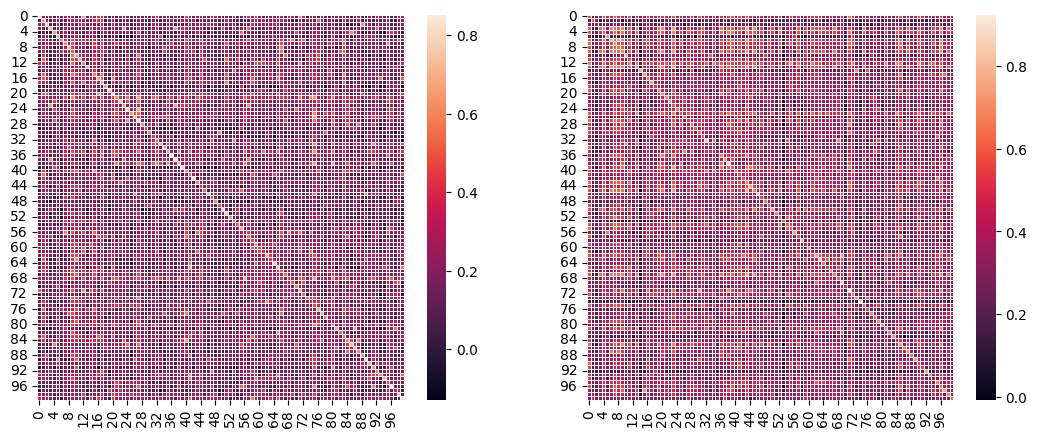

'----------------------------------------------------------------------------------------------------'

'MODEL: TimKond/S-BioLinkBert-MedQuAD'

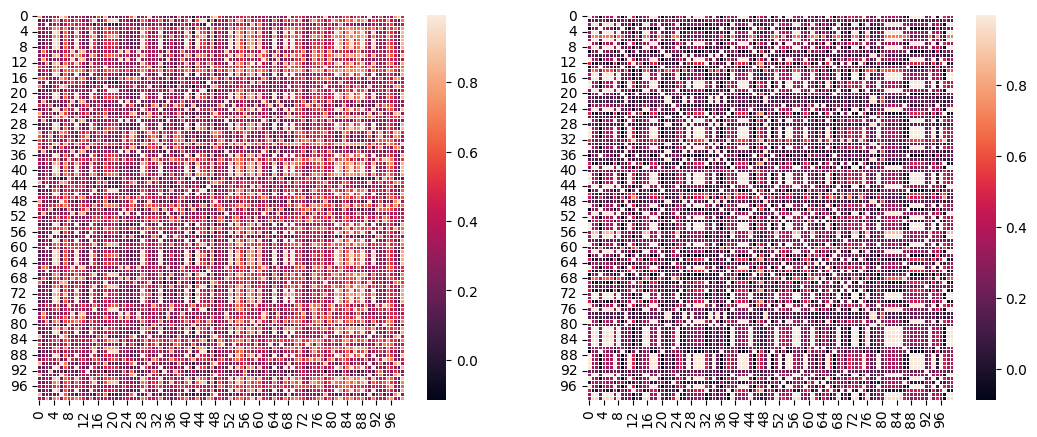

'----------------------------------------------------------------------------------------------------'

'MODEL: TimKond/S-PubMedBert-MedQuAD'

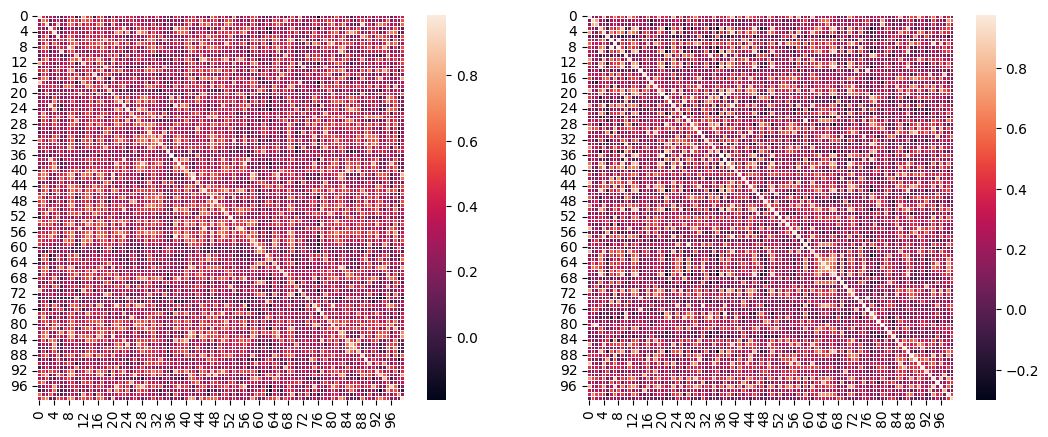

'----------------------------------------------------------------------------------------------------'

'MODEL: kamalkraj/bioelectra-base-discriminator-pubmed'

Some weights of the model checkpoint at kamalkraj/bioelectra-base-discriminator-pubmed were not used when initializing ElectraModel: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


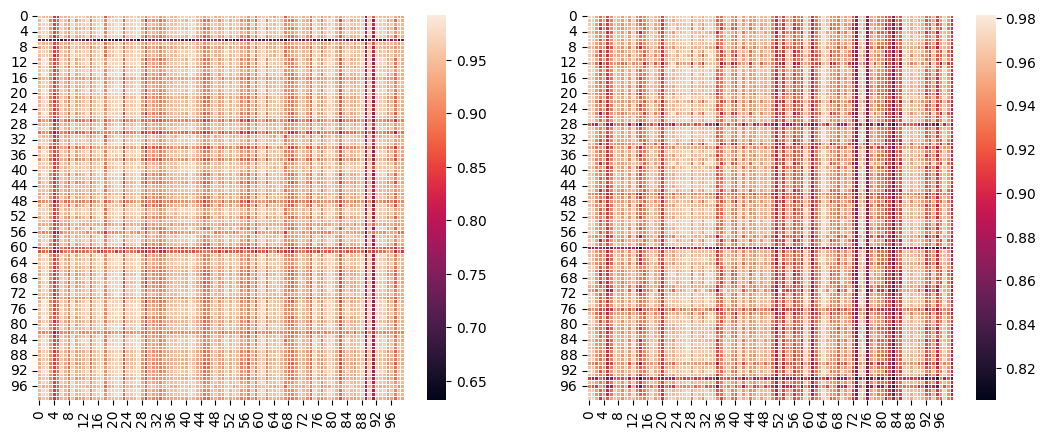

'----------------------------------------------------------------------------------------------------'

In [12]:
import seaborn as sns
import matplotlib.pylab as plt

# very simple print heatmap of similarity matrix (answers*questions)
# it should be somewhat similar to diagonal matrix

sub_sample_to_show = 100
batch_to_process = 5

for m in models_to_test:
    display("MODEL: "+m)
    emb_model = EmbedModel(m, device=device)
    datalist = [data, data1]
    fig, axs = plt.subplots(1, len(datalist), figsize=(13,5))
    for i, d in enumerate(datalist):
        exp_embedded = encode_db(d['A'].tolist()[:sub_sample_to_show], emb_model, tqdm_flag=False, batch_len=batch_to_process)
        questions_embedded = encode_db(d['Q'].tolist()[:sub_sample_to_show], emb_model, tqdm_flag=False, batch_len=batch_to_process)
        a = exp_embedded.cpu() @ questions_embedded.cpu().T

        sns.heatmap(a, linewidth=0.5, ax=axs[i])
    plt.show()
    display("-"*100)

In [ ]:
models_to_test = [
    "emilyalsentzer/Bio_ClinicalBERT", # hmmmmm, ok?
    "medicalai/ClinicalBERT", # a bit better than Bio_ClinicalBERT
    "pritamdeka/S-Biomed-Roberta-snli-multinli-stsb", # nice
    # "menadsa/S-Bio_ClinicalBERT", broken???
    "menadsa/S-BioELECTRA", # nice
    "TimKond/S-BioLinkBert-MedQuAD", # medquad only?
    "TimKond/S-PubMedBert-MedQuAD", # nice
    "kamalkraj/bioelectra-base-discriminator-pubmed" # very very meh
]